In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras 
from keras.models import Sequential 
from keras.layers import Dense,GlobalAveragePooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt 
import seaborn as sns
import tqdm 
from sklearn.model_selection import train_test_split 
from keras.applications import inception_resnet_v2
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import glob 
import cv2

In [2]:
import pathlib

dataset = pathlib.Path("lung_colon_image_set/lung_image_sets/")
images = list(dataset.glob('*/*.jpeg'))

In [3]:
lbt = dataset.glob('lung_n/*')
laca = dataset.glob('lung_aca/*')
lscc = dataset.glob('lung_scc/*')

lung_benign_tissue = list(lbt)
lung_adenocarcinoma = list(laca)
lung_squamous_cell_carcinoma = list(lscc)

In [4]:
label_dict = {
    'lung_benign_tissue' : 0,
    'lung_adenocarcinoma' : 1,
    'lung_squamous_cell_carcinoma' : 2,
}

image_dict = {
    'lung_benign_tissue' : lung_benign_tissue,
    'lung_adenocarcinoma' : lung_adenocarcinoma,
    'lung_squamous_cell_carcinoma' : lung_squamous_cell_carcinoma,
}

In [5]:
x,y = [],[]

for name,images in image_dict.items():
    for img in images:
        i = cv2.imread(str(img))
        resized_image = cv2.resize(i,(200,200))
        resized_image = resized_image.astype(np.float16)/255.0
        resized_image = np.round(resized_image,4)
        x.append(resized_image)
        y.append(label_dict[name])

x = np.array(x)
y = np.array(y)

In [6]:
x

array([[[[0.6353, 0.2196, 0.3452],
         [0.5527, 0.1372, 0.341 ],
         [0.647 , 0.1804, 0.4749],
         ...,
         [0.7764, 0.7256, 0.866 ],
         [0.7725, 0.7334, 0.866 ],
         [0.7764, 0.7607, 0.855 ]],

        [[0.565 , 0.1686, 0.2627],
         [0.537 , 0.098 , 0.2627],
         [0.5605, 0.0824, 0.3215],
         ...,
         [0.749 , 0.7607, 0.8433],
         [0.7646, 0.749 , 0.835 ],
         [0.8037, 0.7646, 0.8433]],

        [[0.5605, 0.1647, 0.247 ],
         [0.51  , 0.0353, 0.1608],
         [0.4749, 0.0118, 0.1882],
         ...,
         [0.6943, 0.745 , 0.828 ],
         [0.718 , 0.741 , 0.8394],
         [0.749 , 0.7256, 0.855 ]],

        ...,

        [[0.71  , 0.51  , 0.8   ],
         [0.7217, 0.4824, 0.788 ],
         [0.6743, 0.408 , 0.7295],
         ...,
         [0.702 , 0.3372, 0.718 ],
         [0.714 , 0.4197, 0.792 ],
         [0.6904, 0.3293, 0.6943]],

        [[0.698 , 0.4587, 0.792 ],
         [0.6904, 0.4236, 0.749 ],
         [0.

In [7]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=10)

In [8]:
x_train.shape

(10500, 200, 200, 3)

In [9]:
# x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,train_size=0.5,random_state=10)

In [10]:
model = Sequential()
inc_res_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(200,200,3))
model.add(inc_res_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(3,activation='softmax'))

for layer in inc_res_model.layers:
    layer.trainable = False

y_train_cat = to_categorical(y_train, num_classes=3)
# y_val_cat = to_categorical(y_val, num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 3)                 4611      
                                                                 
Total params: 54341347 (207.30 MB)
Trainable params: 4611 (18.01 KB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [11]:
history = model.fit(x_train,y_train_cat,epochs=5,batch_size=8)

Epoch 1/5
1313/1313 [==============================] - 571s 424ms/step - loss: 0.1888 - accuracy: 0.9290
Epoch 2/5
1313/1313 [==============================] - 1294s 986ms/step - loss: 0.1145 - accuracy: 0.9549
Epoch 3/5
1313/1313 [==============================] - 572s 435ms/step - loss: 0.1015 - accuracy: 0.9578
Epoch 4/5
1313/1313 [==============================] - 583s 444ms/step - loss: 0.0874 - accuracy: 0.9649
Epoch 5/5
1313/1313 [==============================] - 583s 444ms/step - loss: 0.0822 - accuracy: 0.9673


In [12]:
model_hist=pd.DataFrame(history.history)

In [21]:
y_test_cat=to_categorical(y_test,num_classes=3)
model.evaluate(x_test,y_test_cat)

141/141 [==============================] - 229s 2s/step - loss: 0.1127 - accuracy: 0.9584


[0.11272533982992172, 0.9584444165229797]

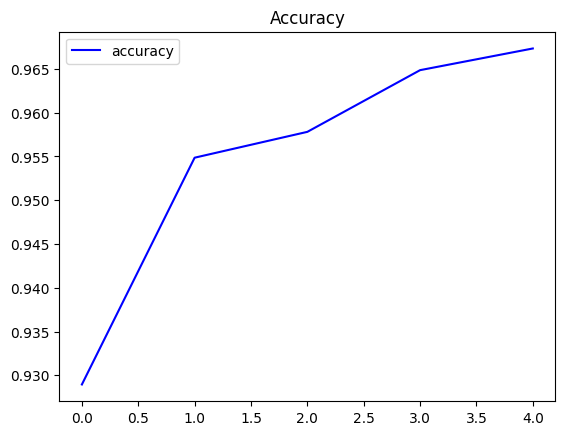

In [22]:
plt.plot(history.history['accuracy'],color='blue',label='accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

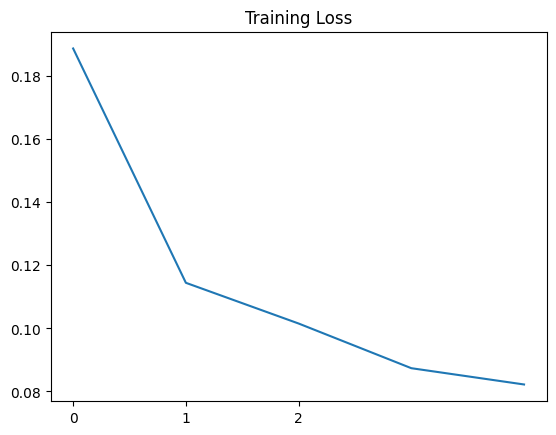

In [23]:
x=list(range(0,3))
plt.plot(model_hist['loss'])
plt.xticks(x)
plt.title("Training Loss")
plt.show()

In [24]:
y_pred_model=model.predict(x_test)
y_pred_model=np.argmax(y_pred_model,axis=1)
print(classification_report(y_pred_model,y_test))

141/141 [==============================] - 230s 2s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1480
           1       0.99      0.90      0.94      1703
           2       0.88      0.99      0.93      1317

    accuracy                           0.96      4500
   macro avg       0.96      0.96      0.96      4500
weighted avg       0.96      0.96      0.96      4500



In [25]:
accuracy_score(y_test,y_pred_model)

0.9584444444444444

<Axes: >

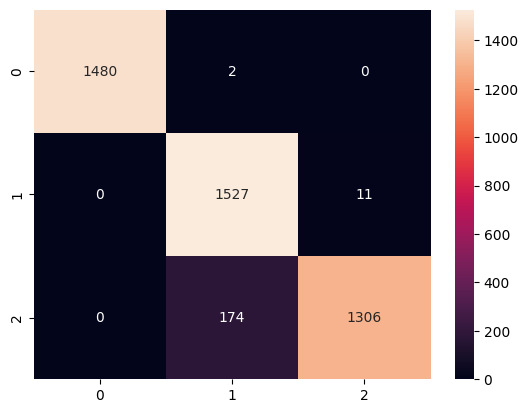

In [26]:
sns.heatmap(confusion_matrix(y_test,y_pred_model),annot=True,fmt='d')